In [23]:
from scipy.integrate import quad
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [43]:
def load_file_paths(base_dir):
    file_paths = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file == "chemical_and_SN_evolution.txt":
                file_paths.append(os.path.join(root, file))
    return file_paths

def load_data_with_names(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {}
    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith("#"):
            row_name = line[1:].strip()
            if i + 1 < len(lines):
                data = list(map(float, lines[i + 1].strip().split()))
                data_dict[row_name] = data
    return data_dict

def recalculate(logNO, logOH): # Recalculate logNO and logOH
    logNO = [i + 0.86 for i in logNO]
    logOH = [i + 8.696 for i in logOH]
    return logNO, logOH

def fit(logOH, logNO): # Fit a polynomial to the data
    coefficients = np.polyfit(logOH, logNO, deg=6)
    polynomial = np.poly1d(coefficients)
    smooth_logOH = np.linspace(min(logOH[6:]), max(logOH[6:]), 500)
    smooth_logNO = polynomial(smooth_logOH)
    return smooth_logOH, smooth_logNO

def prepare_data(file_paths):
    for path in file_paths:
        data = load_data_with_names(path)
        logNO, logOH = data['Gas [N/O]:'], data['Gas [O/H]:']
        FeH, MgH, OH = data['Gas [Fe/H]:'], data['Gas [Mg/H]:'], data['Gas [O/H]:']
        timestep = data['time step list:']
        logNO_rec, logOH_rec = recalculate(logNO, logOH)
        smooth_logOH, smooth_logNO = fit(logOH_rec, logNO_rec)
    return smooth_logOH, smooth_logNO

def plot_Bekki_comparison():
    patha115 = "./Bekki paper stolen plots/alpha115.csv"
    patha155 = "./Bekki paper stolen plots/alpha155.csv"
    patha235 = "./Bekki paper stolen plots/alpha235.csv"
    pathdwarf = "./Bekki paper stolen plots/dwarf.csv"

    a115 = np.loadtxt(patha115, delimiter=',')
    a155 = np.loadtxt(patha155, delimiter=',')
    a235 = np.loadtxt(patha235, delimiter=',')
    dwarf = np.loadtxt(pathdwarf, delimiter=',')

    BlogOHa115 = a115[:, 0]
    BlogNOa115 = a115[:, 1]
    BlogOHa155 = a155[:, 0]
    BlogNOa155 = a155[:, 1]
    BlogOHa235 = a235[:, 0]
    BlogNOa235 = a235[:, 1]
    BlogOHdwarf = dwarf[:, 0]
    BlogNOdwarf = dwarf[:, 1]

    # plt.rc('font', family='serif')
    plt.plot(BlogOHa155, BlogNOa155, color='orange', lw=1, label='Bekki, $\\alpha=1.55$', linestyle=':')
    plt.plot(BlogOHa115, BlogNOa115, color='purple', lw=1, label='Bekki, $\\alpha=1.15$', linestyle='-')
    plt.plot(BlogOHa235, BlogNOa235, color='brown', lw=1, label='Bekki, $\\alpha=2.35$', linestyle='--')
    plt.plot(BlogOHdwarf, BlogNOdwarf, color='green', lw=1, label='Bekki, dwarf', linestyle='-.')
    plt.scatter(7.559841776058438, -0.4, color='black', label='Bekki', s=30, marker='*')
    plt.scatter(7.91, -0.2, color='red', label='Observations', s=30, marker='*')

def plot_NO_OH_comparison(file_paths, labels, index_x, index_y, title, filename):  
    colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k']  # Extend if needed
    plt.rc('font', family='serif')
    for i, path in enumerate(file_paths):
        data = load_data_with_names(path)
        logNO, logOH = data['Gas [N/O]:'], data['Gas [O/H]:']
        logNO, logOH = recalculate(logNO, logOH)
        smooth_logOH, smooth_logNO = fit(logOH, logNO)
        label = labels[i] if labels and i < len(labels) else f"Run {i+1}"
        plt.plot(smooth_logOH[index_x:index_y], smooth_logNO[index_x:index_y], color=colors[i % len(colors)], lw=0.8, label=label)
    plot_Bekki_comparison()
    plt.xlabel('12+log(O/H)', fontsize=14)
    plt.ylabel('log(N/O)', fontsize=14)
    plt.title(title, fontsize=12)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.savefig(filename)
    plt.show()


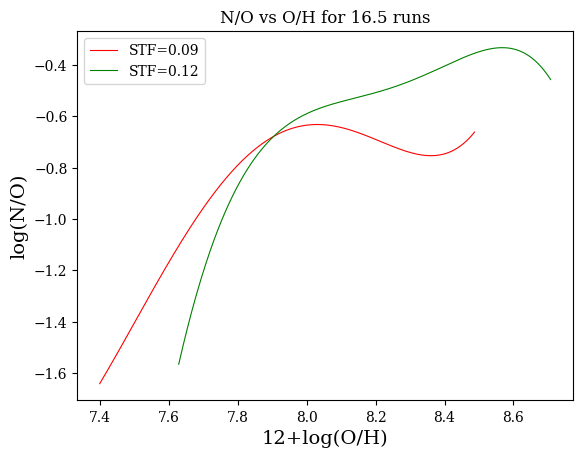

In [11]:
def plot_NO_OH_multi(file_paths, labels, title, filename):
    """
    Plots N/O vs O/H for multiple simulation files on one plot.
    file_paths: list of file paths to simulation results
    labels: list of labels for each line
    """
    plt.rc('font', family='serif')

    colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k']  # Extend if needed

    for i, path in enumerate(file_paths):
        data = load_data_with_names(path)
        logNO, logOH = data['Gas [N/O]:'], data['Gas [O/H]:']
        logNO, logOH = recalculate(logNO, logOH)
        smooth_logOH, smooth_logNO = fit(logOH, logNO)
        plt.plot(
            smooth_logOH, smooth_logNO,
            color=colors[i % len(colors)],
            lw=0.8,
            label=labels[i] if labels else f"Run {i+1}"
        )

    plt.xlabel('12+log(O/H)', fontsize=14)
    plt.ylabel('log(N/O)', fontsize=14)
    plt.title(title, fontsize=12)
    plt.legend()
    plt.savefig(filename, dpi=300)
    plt.show()

# Example usage:
file_paths = [
    "./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.55Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt",
    "./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.15alpha1.55Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt",
    # ...add more paths as needed
]
labels = ['STF=0.09', 'STF=0.12']  # ...add more labels as needed

plot_NO_OH_multi(
    file_paths,
    labels,
    title='N/O vs O/H for 16.5 runs',
    filename='NO_OH_16.5_all.png'
)

In [ ]:
# save data to variable and recalculate axes

# outflow=100
# pathstf009out = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.09alpha1.55SFR0.1SFEN0.66Z_0-4.15outflow100/chemical_and_SN_evolution.txt"
# pathstf012out = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.12alpha1.55SFR0.1SFEN0.66Z_0-4.15outflow100/chemical_and_SN_evolution.txt"
# pathstf015out = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.15alpha1.55SFR0.1SFEN0.66Z_0-4.15outflow100/chemical_and_SN_evolution.txt"
# pathstf018out = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.18alpha1.55SFR0.1SFEN0.66Z_0-4.15outflow100/chemical_and_SN_evolution.txt"

# stf009out = load_data_with_names(pathstf009out)
# stf012out = load_data_with_names(pathstf012out)
# stf015out = load_data_with_names(pathstf015out)
# stf018out = load_data_with_names(pathstf018out)

# outflow=100
# logNOstf009out = stf009out['Gas [N/O]:']
# logOHstf009out = stf009out['Gas [O/H]:']
# logNOstf009out, logOHstf009out = recalculate(logNOstf009out, logOHstf009out)

# logNOstf012out = stf012out['Gas [N/O]:']
# logOHstf012out = stf012out['Gas [O/H]:']
# logNOstf012out, logOHstf012out = recalculate(logNOstf012out, logOHstf012out)

# logNOstf015out = stf015out['Gas [N/O]:']
# logOHstf015out = stf015out['Gas [O/H]:']
# logNOstf015out, logOHstf015out = recalculate(logNOstf015out, logOHstf015out)

# logNOstf018out = stf018out['Gas [N/O]:']
# logOHstf018out = stf018out['Gas [O/H]:']
# logNOstf018out, logOHstf018out = recalculate(logNOstf018out, logOHstf018out)

In [ ]:
#plot sfh
#time = np.linspace(0, max(timestep), sfh.size)/1e9

# plt.rc('font', family='serif')
# plt.figure(figsize=(8, 6))
# plt.plot(time, sfh, color='k', lw=0.8)
# plt.xlabel('Time (Gyr)', fontsize=14)
# plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)', fontsize=14)
# plt.title('Star Formation History', fontsize=16)

In [6]:
# plot log(C/O)-12+log(O/H)

# plt.rc('font', family='serif')
# plt.figure(figsize=(8, 6))
# logCOrec = [i + 0.26 for i in logNO]
# plt.plot(logOHrec[3:], logCOrec[3:], color='k', lw=0.8, label='recalculated')
# plt.xlabel('12+log(O/H)', fontsize=14)
# plt.ylabel('log(C/O)', fontsize=14)
# plt.legend()
# plt.savefig('logOH_logNO_recalculated.png', dpi=300)

Model M1

In [19]:
# paths to the files and load data

# outflow=None
pathstf009 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.09alpha1.55Log_SFR1.3SFEN6.6Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf012 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.12alpha1.55Log_SFR1.3SFEN6.6Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf015 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.15alpha1.55Log_SFR1.3SFEN6.6Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf018 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.18alpha1.55Log_SFR1.3SFEN6.6Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf024 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.24alpha1.55Log_SFR1.3SFEN6.6Z_0-4.15/chemical_and_SN_evolution.txt"

plot_NO_OH_comparison(
    pathstf009, pathstf012=pathstf012, pathstf015=pathstf015, pathstf018=pathstf018, pathstf024=pathstf024,
    title='Comparison of N/O vs O/H for $\\alpha=1.55$, SFR=20 M$_\odot$/yr, SFEN=66 Myr',
    filename='NO_OH_comparison_a=1,55_sfr=20_sfen=6,6.png'
)


TypeError: plot_NO_OH_comparison() got an unexpected keyword argument 'pathstf012'

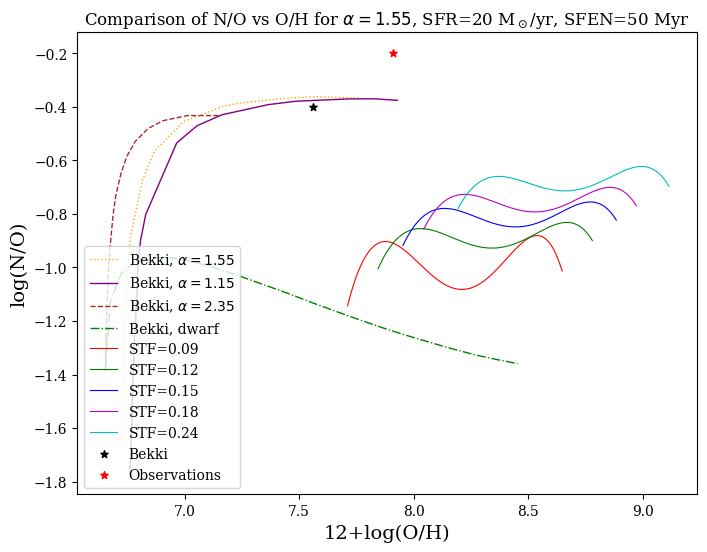

In [115]:
# outflow=None
pathstf009 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.09alpha1.55Log_SFR1.3SFEN5Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf012 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.12alpha1.55Log_SFR1.3SFEN5Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf015 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.15alpha1.55Log_SFR1.3SFEN5Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf018 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.18alpha1.55Log_SFR1.3SFEN5Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf024 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.24alpha1.55Log_SFR1.3SFEN5Z_0-4.15/chemical_and_SN_evolution.txt"

plot_NO_OH_comparison(
    pathstf009, pathstf012=pathstf012, pathstf015=pathstf015, pathstf018=pathstf018, pathstf024=pathstf024,
    title='Comparison of N/O vs O/H for $\\alpha=1.55$, SFR=20 M$_\odot$/yr, SFEN=50 Myr',
    filename='NO_OH_comparison_a=1,55_sfr=20_sfen=5.png'
)

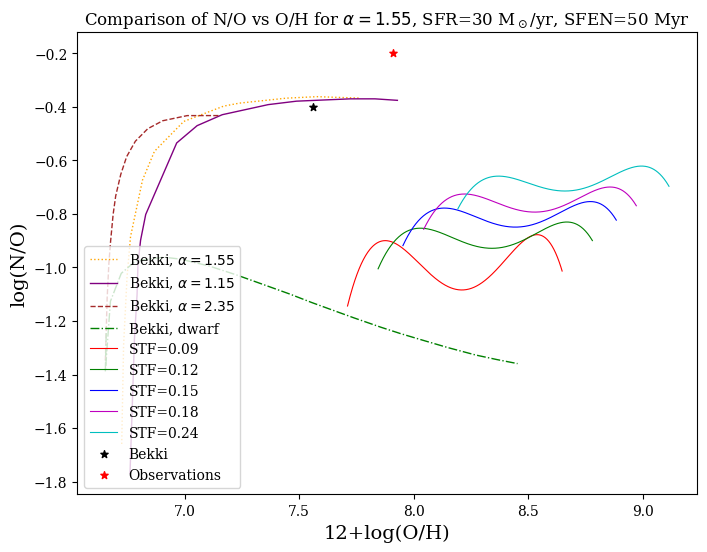

In [123]:
# outflow=None
pathstf009 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.09alpha1.55Log_SFR1.5SFEN5Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf012 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.12alpha1.55Log_SFR1.5SFEN5Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf015 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.15alpha1.55Log_SFR1.5SFEN5Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf018 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.18alpha1.55Log_SFR1.5SFEN5Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf024 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.24alpha1.55Log_SFR1.5SFEN5Z_0-4.15/chemical_and_SN_evolution.txt"

plot_NO_OH_comparison(
    pathstf009, pathstf012=pathstf012, pathstf015=pathstf015, pathstf018=pathstf018, pathstf024=pathstf024,
    title='Comparison of N/O vs O/H for $\\alpha=1.55$, SFR=30 M$_\odot$/yr, SFEN=50 Myr',
    filename='NO_OH_comparison_a=1,55_sfr=30_sfen=5.png'
)

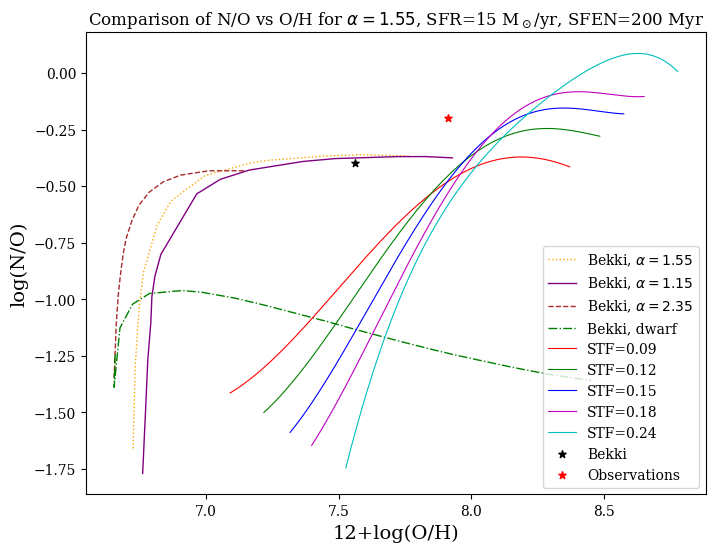

In [6]:
# outflow=None
pathstf009 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.09alpha1.55Log_SFR1.2SFEN20Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf012 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.12alpha1.55Log_SFR1.2SFEN20Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf015 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.15alpha1.55Log_SFR1.2SFEN20Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf018 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.18alpha1.55Log_SFR1.2SFEN20Z_0-4.15/chemical_and_SN_evolution.txt"
pathstf024 = "./simulation_results_from_galaxy_evol/imfKroupaSTF0.24alpha1.55Log_SFR1.2SFEN20Z_0-4.15/chemical_and_SN_evolution.txt"

plot_NO_OH_comparison(
    pathstf009, pathstf012=pathstf012, pathstf015=pathstf015, pathstf018=pathstf018, pathstf024=pathstf024,
    title='Comparison of N/O vs O/H for $\\alpha=1.55$, SFR=15 M$_\odot$/yr, SFEN=200 Myr',
    filename='NO_OH_comparison_a=1,55_sfr=15_sfen=200.png'
)

['./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR2.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.7SFEN15Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.7SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt', './simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR2.0SFEN15Z_0-4.15/chemical_and_SN_evolution.txt']


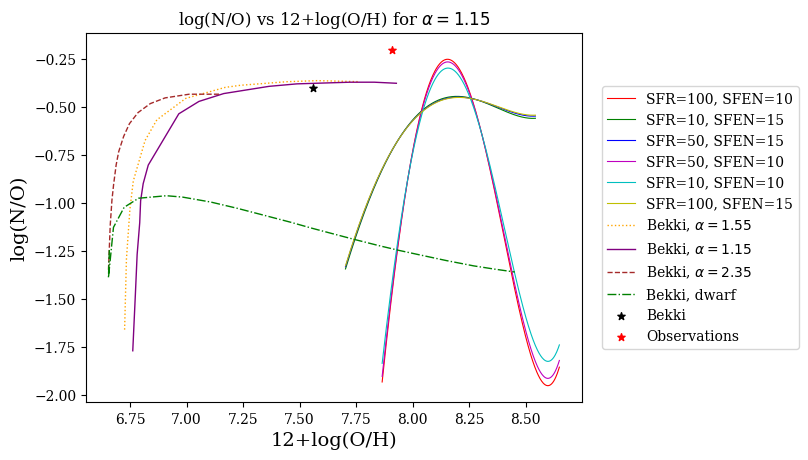

In [51]:
# file_paths = [
#     "./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt",
#     "./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt",
#     "./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt",
#     "./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt",
#     "./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt",
#     "./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt",
#     "./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt",
#     "./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR1.0SFEN10Z_0-4.15/chemical_and_SN_evolution.txt",
# ]
file_paths = glob.glob("./simulation_results_from_galaxy_evol/16.5/imfKroupaSTF0.09alpha1.15Log_SFR*SFEN*Z_0-4.15/chemical_and_SN_evolution.txt")
print(file_paths)
labels = ['SFR=100, SFEN=10', 'SFR=10, SFEN=15', 'SFR=50, SFEN=15', 'SFR=50, SFEN=10', 'SFR=10, SFEN=10', 'SFR=100, SFEN=15']
plot_NO_OH_comparison(
    file_paths,
    labels=labels,
    index_x=110,
    index_y=450,
    title='log(N/O) vs 12+log(O/H) for $\\alpha=1.15$',
    filename='NO_OH_16.5_all.png'
)